<a href="https://www.kaggle.com/code/sagnikdebnath007/fusion-model?scriptVersionId=204833026" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/meld-embeddings/text_embeddings.pkl
/kaggle/input/meld-embeddings/audi_embeddings.pkl
/kaggle/input/meld-embeddings/text_encodings_reduced.pkl
/kaggle/input/meld-embeddings/train_sent_emo.csv


In [2]:
import pickle
with open('/kaggle/input/meld-embeddings/audi_embeddings.pkl', 'rb') as f:
    audi_enc = pickle.load(f)

In [3]:
audi_enc[0].shape

(1611,)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [5]:
df=pd.read_csv('/kaggle/input/meld-embeddings/train_sent_emo.csv')
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [6]:
df['Emotion'].unique()

array(['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust',
       'anger'], dtype=object)

In [7]:
with open('/kaggle/input/meld-embeddings/text_encodings_reduced.pkl', 'rb') as f:
    text_enc = pickle.load(f)

In [8]:
text_enc[0]

array([ 0.11960347,  0.1587823 ,  0.12340884, ...,  0.30313653,
       -0.8035412 , -0.9119101 ], dtype=float32)

In [9]:
fused_enc=[np.concatenate((text, audi)) for text, audi in zip(text_enc, audi_enc)]

In [10]:
len(fused_enc[0])

3222

In [11]:
x=fused_enc
y=df['Emotion']
y

0        neutral
1        neutral
2        neutral
3        neutral
4       surprise
          ...   
9984     neutral
9985     neutral
9986    surprise
9987     neutral
9988         joy
Name: Emotion, Length: 9989, dtype: object

In [12]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)
y

array([4, 4, 4, ..., 6, 4, 3])

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Accuracy: 0.5541
Precision: 0.4636
Recall: 0.5541
F1 Score: 0.4661


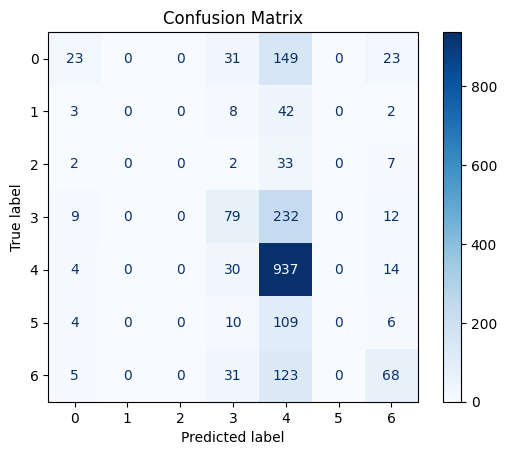

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [14]:
x_tensor=torch.tensor(x,dtype=torch.float32)
y_tensor=torch.tensor(y,dtype=torch.long)

/tmp/ipykernel_30/1046033588.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_tensor=torch.tensor(x,dtype=torch.float32)


In [15]:
class AutoEncoder(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(AutoEncoder,self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(input_dim,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,output_dim)
        )
        self.decoder=nn.Sequential(
            nn.Linear(output_dim,128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,input_dim)
        )
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded

In [16]:
model = AutoEncoder(3222,64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [17]:
dataset = TensorDataset(x_tensor,x_tensor)  
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [18]:
epochs=10
from tqdm import tqdm
for epoch in range(epochs):
    running_loss=0.0
    for batch_data, _ in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        batch_data = batch_data
        optimizer.zero_grad()
        reconstructed = model(batch_data)
        loss = criterion(reconstructed, batch_data)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    avg_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 1249/1249 [00:53<00:00, 23.33it/s]


Epoch [1/10], Loss: 0.2030


Epoch 2/10: 100%|██████████| 1249/1249 [01:06<00:00, 18.70it/s]


Epoch [2/10], Loss: 0.1501


Epoch 3/10: 100%|██████████| 1249/1249 [01:09<00:00, 18.07it/s]


Epoch [3/10], Loss: 0.1303


Epoch 4/10: 100%|██████████| 1249/1249 [01:11<00:00, 17.57it/s]


Epoch [4/10], Loss: 0.1185


Epoch 5/10: 100%|██████████| 1249/1249 [01:11<00:00, 17.42it/s]


Epoch [5/10], Loss: 0.1102


Epoch 6/10: 100%|██████████| 1249/1249 [01:13<00:00, 17.00it/s]


Epoch [6/10], Loss: 0.1044


Epoch 7/10: 100%|██████████| 1249/1249 [01:13<00:00, 17.03it/s]


Epoch [7/10], Loss: 0.1001


Epoch 8/10: 100%|██████████| 1249/1249 [01:13<00:00, 16.94it/s]


Epoch [8/10], Loss: 0.0968


Epoch 9/10: 100%|██████████| 1249/1249 [01:13<00:00, 17.03it/s]


Epoch [9/10], Loss: 0.0935


Epoch 10/10: 100%|██████████| 1249/1249 [01:14<00:00, 16.78it/s]

Epoch [10/10], Loss: 0.0919


In [19]:
with torch.no_grad():
    x_tensor_reduced = model.encoder(x_tensor)

In [20]:
x_tensor_reduced[0].shape

torch.Size([64])

In [21]:
x_reduced = [encoding.numpy() for encoding in x_tensor_reduced]

In [22]:
type(x_reduced[0])

numpy.ndarray

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Accuracy: 0.5475
Precision: 0.4649
Recall: 0.5475
F1 Score: 0.4770


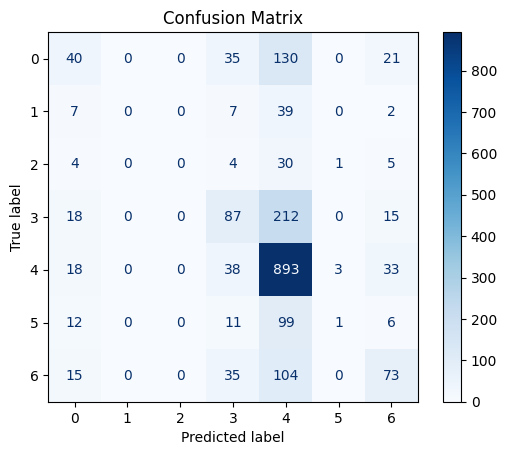

In [24]:
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [25]:
from xgboost import XGBClassifier

Classification Accuracy: 0.5315
Precision: 0.4515
Recall: 0.5315
F1 Score: 0.4744


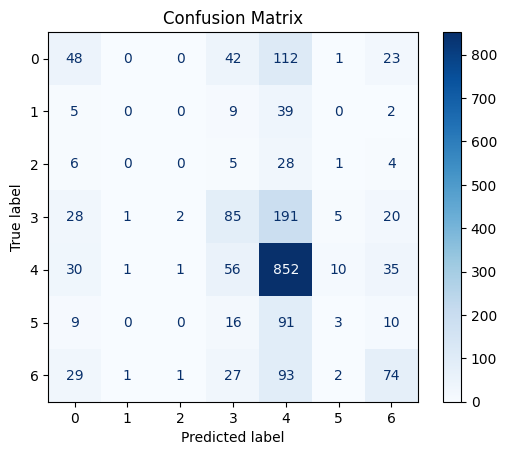

In [26]:
model3=XGBClassifier(n_estimators=50)
model3.fit(X_train, y_train)

y_pred = model3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [27]:
from sklearn.ensemble import AdaBoostClassifier

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Accuracy: 0.5410
Precision: 0.4517
Recall: 0.5410
F1 Score: 0.4685


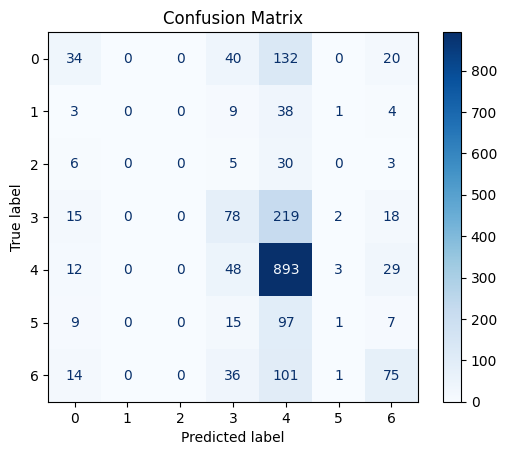

In [28]:
model4=AdaBoostClassifier(estimator=model2,n_estimators=100,learning_rate=0.01)
model4.fit(X_train, y_train)

y_pred = model4.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

Classification Accuracy: 0.5355
Precision: 0.4568
Recall: 0.5355
F1 Score: 0.4749


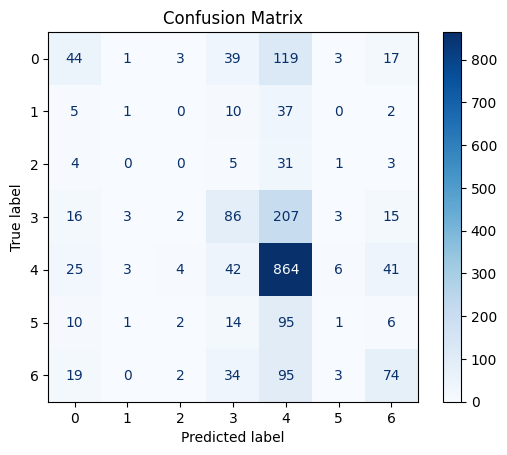

In [30]:
model5=GradientBoostingClassifier()
model5.fit(X_train, y_train)

y_pred = model5.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

So here we have fused the audio and text encodings and have reduced the dimensionality of those from 3222 to 64. We find that we get the best possible F1 score on using Random Forest Classifier with 100 estimators 